In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression

In [2]:
COL_POINTS = "#3B4859"
COL_LINES = "#FF7373"

### 3.8 L'arbitrage entre Precision et Recall

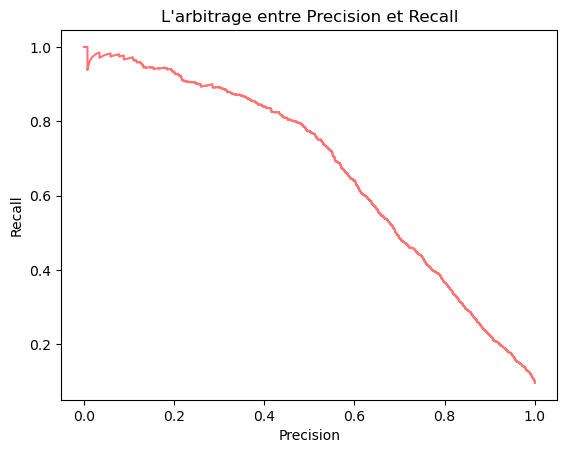

In [27]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"].astype(int)
X_train, X_test, y_train, y_test = X[:20000], X[-5000:], y[:20000], y[-5000:]

n = 8
y_train_n = (y_train == n)

sgd_clf = SGDClassifier(random_state=42, loss="log_loss")
sgd_clf.fit(X_train, y_train_n)

y_scores = cross_val_predict(sgd_clf, X_train, y_train_n, cv=3,
                             method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_n, y_scores)

plt.plot(recalls, precisions, c=COL_LINES, label="Recall")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("L'arbitrage entre Precision et Recall")

plt.savefig("precision_recall_arbitrage.png")

### 5.10 Régression : fonction de prédiction

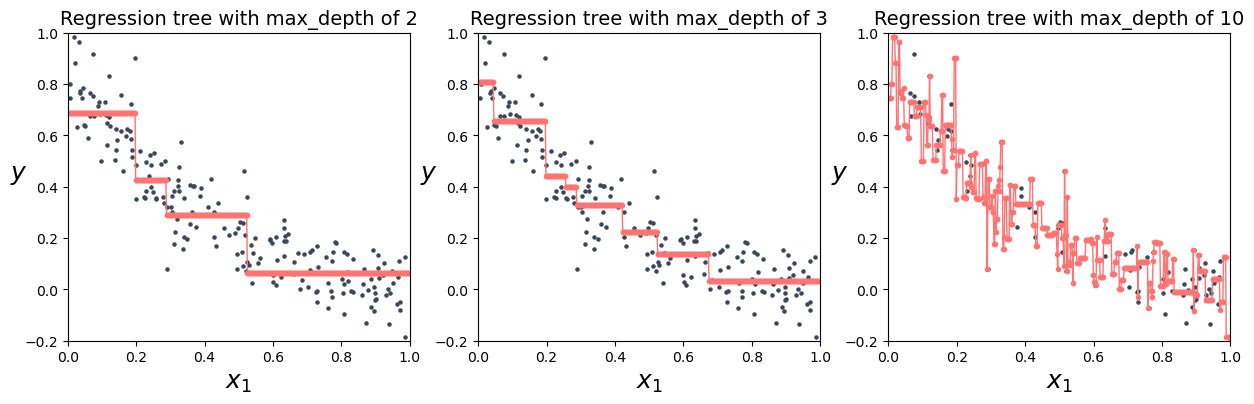

In [26]:
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 0.8 * (X - 1) ** 2
y = y + np.random.randn(m, 1) / 10
y = y.reshape(200)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.scatter(X, y, s=5, color=COL_POINTS)
    plt.plot(x1, y_pred, ".-", color=COL_LINES, linewidth=1)
    
    
max_depths = [2, 3, 10]
n_plots = len(max_depths)
fig, axes = plt.subplots(ncols=n_plots, figsize=(5*n_plots, 4))
for i, md in enumerate(max_depths):
    tree_reg = DecisionTreeRegressor(random_state=42, max_depth=md)
    tree_reg.fit(X, y)
    plt.sca(axes[i])
    plot_regression_predictions(tree_reg, X, y)
    plt.title(f"Regression tree with max_depth of {md}", fontsize=14)

plt.savefig("reg_tree_compar.png")

### 6.4 Bagging pour la régression

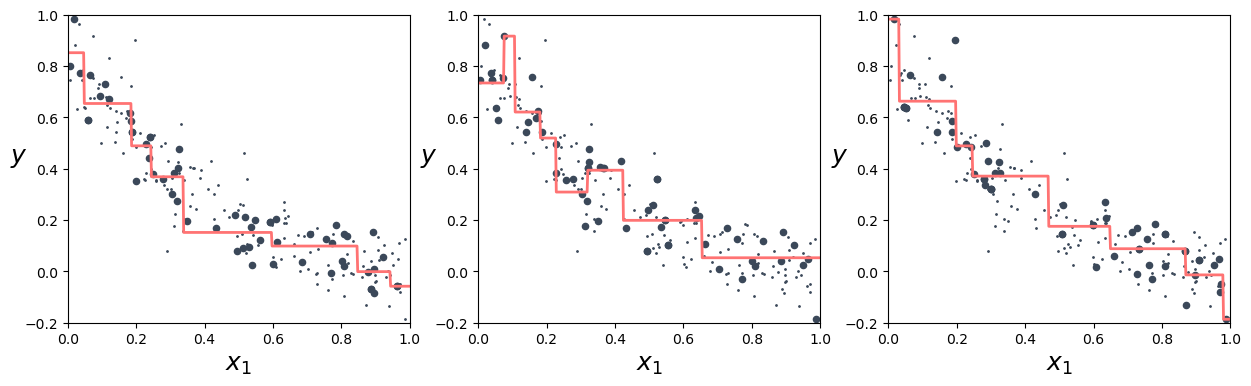

In [24]:
def plot_regression_predictions(tree_reg, X_sub, y_sub, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.scatter(X, y, s=1, color=COL_POINTS)
    plt.plot(x1, y_pred, "-", color=COL_LINES, linewidth=2)
    plt.scatter(X_sub, y_sub, s=20, color=COL_POINTS)
    
n_plots = 3
n_samples = int(0.3*len(y))

fig, axes = plt.subplots(ncols=n_plots, figsize=(5*n_plots, 4))
for i, md in enumerate(range(n_plots)):
    subsamples = np.random.randint(0, 200, n_samples)
    X_sub = X[subsamples]
    y_sub = y[subsamples]
    tree_reg = DecisionTreeRegressor(max_depth=3)
    tree_reg.fit(X_sub, y_sub)
    plt.sca(axes[i])
    plot_regression_predictions(tree_reg, X_sub, y_sub)
    
plt.savefig(f"reg_bootstrap_trees_indiv.png")

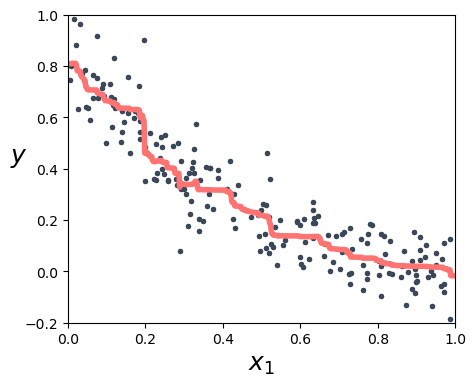

In [25]:
def plot_regression_predictions(tree_reg, X_sub, y_sub, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.scatter(X, y, s=8, color=COL_POINTS)
    plt.plot(x1, y_pred, "-", color=COL_LINES, linewidth=4)
    plt.scatter(X_sub, y_sub, s=8, color=COL_POINTS)

fig, axes = plt.subplots(ncols=1, figsize=(5, 4))
bagged_trees = BaggingRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=3),
    n_estimators=1000,
)
_ = bagged_trees.fit(X, y)
plot_regression_predictions(bagged_trees, X, y)
plt.savefig(f"reg_bootstrap.png")

### 6.9 AdaBoost pour la régression

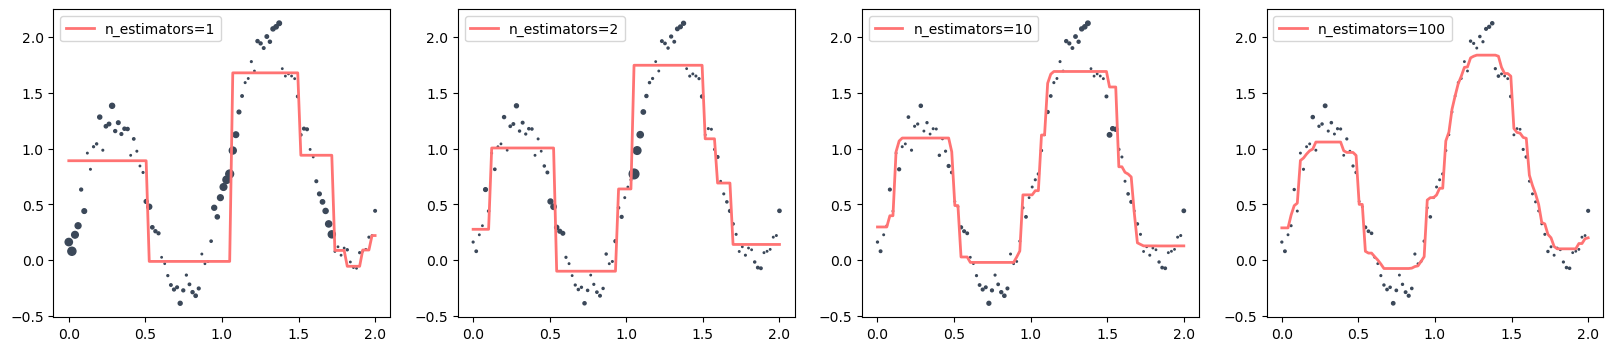

In [28]:
def pointwise_squared_error(y_true, y_pred):
    return (y_pred - y_true)**2

# Create the dataset
rng = np.random.RandomState(1)
X = np.linspace(0, 2, 100)[:, np.newaxis]
y = np.sin(X).ravel() + np.sin(6 * X).ravel() + rng.normal(0, 0.1, X.shape[0])

n_estimators = [1, 2, 10, 100]
fig, axes = plt.subplots(ncols=len(n_estimators), figsize=(5*len(n_estimators), 4))
for i, n_est in enumerate(n_estimators):
    regr = AdaBoostRegressor(
        DecisionTreeRegressor(max_depth=3), n_estimators=n_est, random_state=rng
    )
    regr.fit(X, y)
    y_pred = regr.predict(X)

    # Plot the results
    axes[i].scatter(X, y, c=COL_POINTS, s=pointwise_squared_error(y, y_pred)*50+1)
    axes[i].plot(X, y_pred, c=COL_LINES, linewidth=2, label=f"n_estimators={n_est}")
    axes[i].legend()
plt.savefig(f"reg_ada_boosting.png")

### 6.11 Gradient Boosting pour la régression

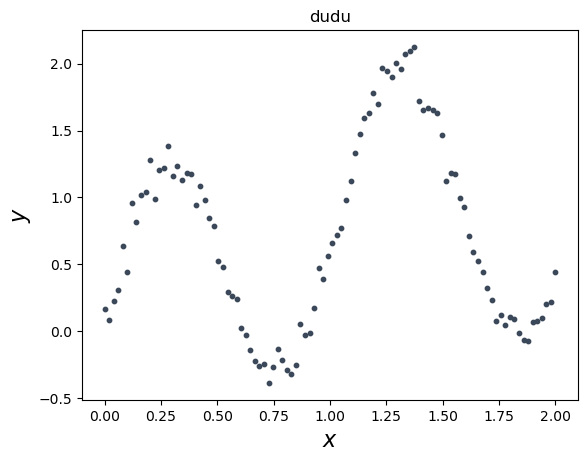

In [21]:
rng = np.random.RandomState(1)
X = np.linspace(0, 2, 100)[:, np.newaxis]
y = np.sin(X).ravel() + np.sin(6 * X).ravel() + rng.normal(0, 0.1, X.shape[0])

plt.scatter(X[:, 0], y, s=10, c=COL_POINTS)
plt.xlabel("$x$", fontsize=16)
plt.ylabel("$y$", fontsize=16)
plt.title("Observed value")
plt.savefig(f"data_grad_boosting.png")

<Figure size 2000x800 with 0 Axes>

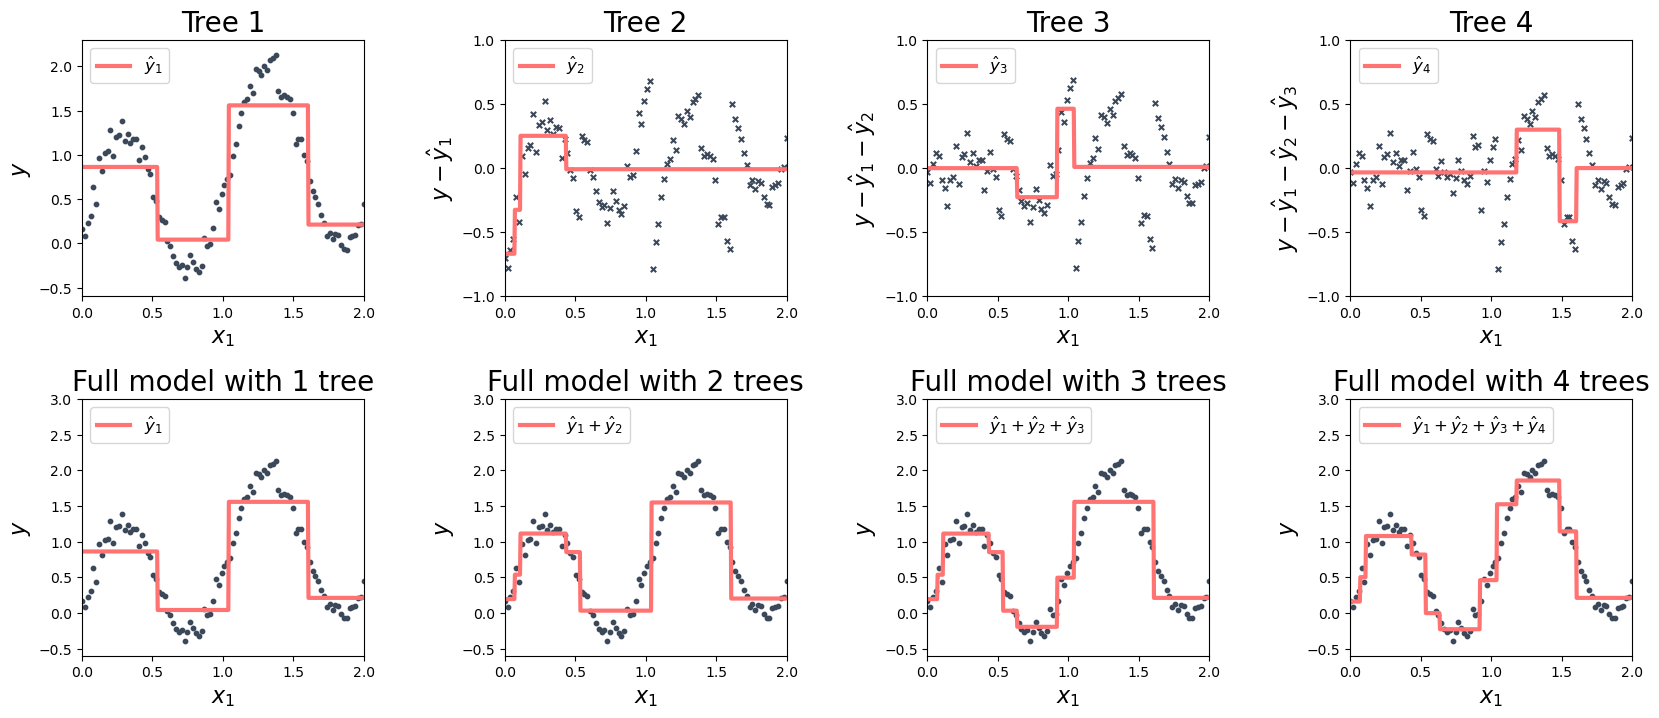

In [17]:
rng = np.random.RandomState(1)
X = np.linspace(0, 2, 100)[:, np.newaxis]
y = np.sin(X).ravel() + np.sin(6 * X).ravel() + rng.normal(0, 0.1, X.shape[0])

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

y4 = y3 - tree_reg3.predict(X)
tree_reg4 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg4.fit(X, y4)

def plot_predictions(regressors, X, y, axes, label=None, residuals=False):
    X_array = X.reshape(X.shape[0])
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(x1, y_pred, c=COL_LINES, linewidth=3, label=label)
    if residuals:
        plt.scatter(X[:, 0], y, s=15, c=COL_POINTS, marker="x")
    else:
        plt.scatter(X[:, 0], y, s=10, c=COL_POINTS)
    plt.legend(loc="upper left", fontsize=12)
    plt.axis(axes)

plt.figure(figsize=(20, 8))
plt.figure(figsize=(20, 8))

plt.subplot(241)
plot_predictions([tree_reg1], X, y, axes=[0, 2, -0.6, 2.3], label="$\hat{y}_1$")
plt.ylabel("$y$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)
plt.title("Tree 1", fontsize= 20)

plt.subplot(242)
plot_predictions([tree_reg2], X, y2, axes=[0, 2, -1, 1], label="$\hat{y}_2$", residuals=True)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y-\hat{y}_1$", fontsize=16)
plt.title("Tree 2", fontsize= 20)
plt.yticks([-1, -0.5, 0, 0.5, 1])

plt.subplot(243)
plot_predictions([tree_reg3], X, y3, axes=[0, 2, -1, 1], label="$\hat{y}_3$", residuals=True)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y-\hat{y}_1-\hat{y}_2$", fontsize=16)
plt.title("Tree 3", fontsize= 20)
plt.yticks([-1, -0.5, 0, 0.5, 1])

plt.subplot(244)
plot_predictions([tree_reg4], X, y4, axes=[0, 2, -1, 1], label="$\hat{y}_4$", residuals=True)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y-\hat{y}_1-\hat{y}_2-\hat{y}_3$", fontsize=16)
plt.title("Tree 4", fontsize= 20)
plt.yticks([-1, -0.5, 0, 0.5, 1])

plt.subplot(245)
plot_predictions([tree_reg1], X, y, axes=[0, 2, -0.6, 3], label="$\hat{y}_1$")
plt.ylabel("$y$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)
plt.title("Full model with 1 tree", fontsize= 20)

plt.subplot(246)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[0, 2, -0.6, 3], label="$\hat{y}_1+\hat{y}_2$")
plt.ylabel("$y$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)
plt.title("Full model with 2 trees", fontsize= 20)

plt.subplot(247)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[0, 2, -0.6, 3], label="$\hat{y}_1+\hat{y}_2+\hat{y}_3$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16)
plt.title("Full model with 3 trees", fontsize= 20)

plt.subplot(248)
plot_predictions([tree_reg1, tree_reg2, tree_reg3, tree_reg4], X, y, axes=[0, 2, -0.6, 3], label="$\hat{y}_1+\hat{y}_2+\hat{y}_3+\hat{y}_4$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16)
plt.title("Full model with 4 trees", fontsize= 20)

plt.subplots_adjust(wspace=0.5, hspace= 0.4)

plt.savefig(f"reg_grad_boosting.png")

### 7.6 Détecter et résoudre le sous-apprentissage

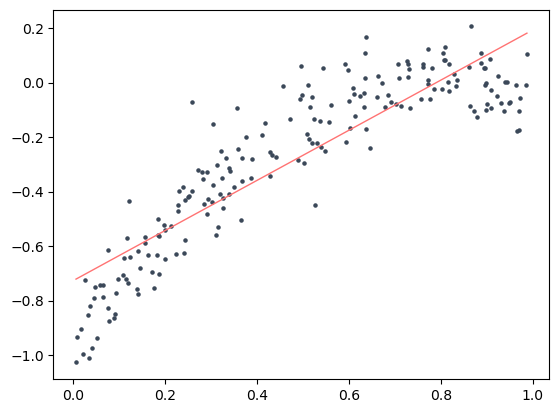

In [79]:
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
X = np.sort(X.ravel())[:, np.newaxis]
y = -1.2 * (1.1*X - 0.9) ** 2
y = y + np.random.randn(m, 1) / 10
y = y.reshape(200)

y_pred = LinearRegression().fit(X, y).predict(X)

plt.scatter(X, y, s=5, color=COL_POINTS)
plt.plot(X, y_pred, color=COL_LINES, linewidth=1)

### 7.7 Détecter et résoudre le sur-apprentissage

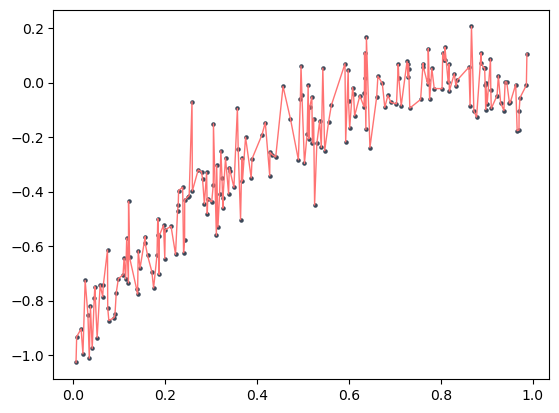

In [80]:
y_pred = DecisionTreeRegressor().fit(X, y).predict(X)

plt.scatter(X, y, s=5, color=COL_POINTS)
plt.plot(X, y_pred, color=COL_LINES, linewidth=1)